In [1]:
import warnings
warnings.filterwarnings("ignore")
import os, json
import pandas as pd
import anndata as ad
import scanpy as sc
import squidpy as sq
import numpy as np
from subprocess import call
from collections import defaultdict
from scipy.special import softmax
from pprint import pprint
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score)
from seededntm import compute_tfidf_rep, compute_topic_prior

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
K = 15                           # number of topics
TOPIC_SEEDS_PATH = './topic_seeds.txt'

squidpy==1.6.5


In [2]:
adata = sq.datasets.visium_fluo_adata()
adata.X = adata.raw.X.copy() # we model count data for this demo
adata = adata[:, adata.var.highly_variable]
adata.raw = None
adata

AnnData object with n_obs × n_vars = 2800 × 4000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
cls2id = {cls:ith for ith, cls in enumerate(adata.obs.cluster.unique())}
id2cls = {ith:cls for cls, ith in cls2id.items()}

### Loading topic seeds
A json dump formated as {celltype: {features: [gene1, gene2, ...], topic_index: idx}}

In [4]:
!cat ./topic_seeds.txt

{"Thalamus_2": {"features": ["Cbln1", "Ctxn3", "Cbln4", "Uchl1", "Map1b", "Hlf", "Plcxd2", "Lypd6b", "Tagln3", "Cd59a", "Cbln2", "Stxbp6", "Foxp2", "Stmn1", "Slc17a6", "Lypd6", "Tcf7l2", "Rims3", "Tuba1b", "Lhfpl3"], "topic_index": 0}, "Fiber_tracts": {"features": ["Mbp", "Plp1", "Mobp", "Mal", "Cnp", "Cldn11", "Trf", "Plekhb1", "Mag", "Ermn", "Bcas1", "Tspan2", "Mog", "Qdpr", "Sept4", "Cryab", "Grb14", "Car2", "Gatm", "Gsn"], "topic_index": 1}, "Cortex_2": {"features": ["Ptgds", "Atp1a2", "Ptn", "Camk2a", "Ddn", "Camk2n1", "Gm42418", "Hbb-bs", "Mfge8", "Mgp", "Selenow", "Nptxr", "2900052N01Rik", "Ifitm3", "Dbi", "Hpcal4", "Igf2", "Hba-a2", "Igfbp2", "Vtn"], "topic_index": 2}, "Hypothalamus_2": {"features": ["Pmch", "Hcrt", "Resp18", "Ndn", "6330403K07Rik", "Tmem130", "Nap1l5", "Ahi1", "Dlk1", "Gaa", "Scg2", "Impact", "Sparc", "Zcchc12", "Hap1", "Zwint", "Gnas", "Peg3", "Nrsn2", "Gpx3"], "topic_index": 3}, "Cortex_3": {"features": ["Camk2n1", "Nrgn", "Mef2c", "Atp1a1", "Lamp5", "Rgs4",

In [5]:
with open(TOPIC_SEEDS_PATH, 'r') as ifile:
    marker_genes = json.load(ifile)

- Compute topic prior, i.e., proportions of the counts of pooled seeding markers for each cell type
- Visualize the topic piror by argmax assignment of cell type count proportions
- The prior can be informative but may not be perfect

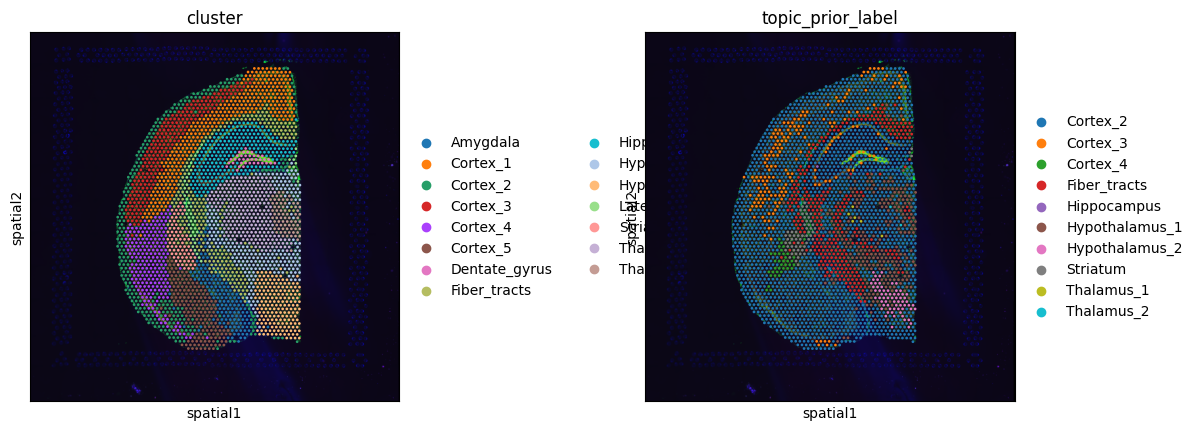

In [6]:
adata.obsm['topic_prior'] = compute_topic_prior(adata, marker_genes, temperature=0.8)
adata.obs['topic_prior_label'] = list(map(lambda i:id2cls[i], np.argmax(adata.obsm['topic_prior'], axis=1)))

if 'topic_prior_label_colors' in adata.uns:
    adata.uns.pop('topic_prior_label_colors')
    
sq.pl.spatial_scatter(adata, spatial_key='spatial', 
                      color=['cluster', 'topic_prior_label']
                     )

In [ ]:
adata.obsm['tfidf_pca'] = compute_tfidf_rep(adata.X, n_pcs=100)
adata.obsm['rna_count'] = adata.X.copy()

In [ ]:
def eval(adata, cls2id, exp_outdir, reg_seed_wt, reg_topic_prior, cls_scores, key_input):
    df_topic = pd.read_csv(os.path.join(exp_outdir, 'df_topic.csv'), index_col=0)
    df_topic.index = adata.obs_names
    id2cls = {v:k for k,v in cls2id.items()}
    adata.obs['topic'] =  [id2cls[idx] for idx in np.argmax(df_topic.values, axis=1).astype(int)]
    adata.obsm['topic_dist'] = df_topic.loc[adata.obs_names]
    adata.obsm['topic_dist'].columns = [f'topic_{k}' for k in range(df_topic.shape[1])]
    
    df_topic_vocab = pd.read_csv(os.path.join(exp_outdir, 'df_topic_vocab.csv'), index_col=0)
    for topic in range(K):
        # adata.obs[f'topic_{topic}'] = (df_topic[f'topic_{topic}'].values).astype(float)
        adata.obs[f'top{topic}({id2cls[topic]})'] = (df_topic[f'topic_{topic}'].values).astype(float)

    sq.pl.spatial_scatter(adata, shape=None, color=['topic', 'cluster'])
    
    sq.pl.spatial_scatter(adata, shape=None, color=[f'top{topic}({id2cls[topic]})' for topic in range(K)])
    ars = adjusted_rand_score(adata.obs.cluster, adata.obs.topic)
    ami = adjusted_mutual_info_score(adata.obs.cluster, adata.obs.topic)
    print("Adjusted Rand Score: ", ars)
    print("Adjusted Mutual Information Score: ", ami)
    cls_scores.append({'key_input':key_input, 'top_seed_wt': reg_seed_wt, 'reg_topic_prior': reg_topic_prior, 'ars': ars,
                       'ami': ami})

In [ ]:
exp_root = './exp_result'
if not os.path.exists(exp_root):
    os.makedirs(exp_root, exist_ok=True)
adata_path = os.path.join(exp_root, 'seededntm_adata_input.h5ad')
adata.write_h5ad(adata_path)
count_out = 'rna_count'
key_topic_prior = 'topic_prior'

reg_seed_wts = [1.0]
reg_topic_priors = [0.9]

cls_scores = []
for key_input in [
                  'tfidf_pca',
                 ]:
    for reg_seed_wt in reg_seed_wts:
        for reg_topic_prior in reg_topic_priors:
            print(f'Start {key_input}')
            exp_string = f"SeedNTM_input_{key_input}_output_rna_seedWt{reg_seed_wt}_priorWt{reg_topic_prior}"
            exp_outdir = os.path.join(exp_root,
                                      exp_string
                                 )
    
            fitted = False
            cmd = ( f'source /home/cqiao/.bashrc; micromamba activate seededntm; export CUBLAS_WORKSPACE_CONFIG=:4096:8; ' +  
                        f'infer_seededntm  --wt_fusion_top_seed {reg_seed_wt} ' +
                        f'--condition_feat_path {TOPIC_SEEDS_PATH} --batch_size 8192 --adata_h5ad_path {adata_path} ' +
                        f'--key_input {key_input} --key_count_out {count_out} --num_topics {K} --exp_outdir {exp_outdir} ' + 
                        f'--key_topic_prior {key_topic_prior} --reg_topic_prior {reg_topic_prior}  ')

            print(cmd)
    
            if call(cmd, shell=True) == 0:
                fitted = True
                eval(adata, cls2id, exp_outdir, reg_seed_wt, reg_topic_prior, cls_scores, key_input)
                
            print(f'Is successful: {fitted}')